# Homework 3: Network Dynamics & Learning

## Problem 1: Epidemic Simulation on a Symmetric k-regular Graph
**Setup**: Ring lattice graph, $n=500, k=4$, SIR model.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

# Set seed for reproducibility
np.random.seed(42)

# --- Problem 1 Parameters ---
n = 500
k = 4
beta = 0.3
rho = 0.7
weeks = 15
n_initial = 10

# Generate Ring Lattice (Watts-Strogatz with p=0)
G_ring = nx.watts_strogatz_graph(n, k, 0)
W_ring = nx.to_scipy_sparse_array(G_ring)



In [3]:
def run_sir_sim(adj, n_nodes, b, r, n_weeks, init_count=10):
    """Runs a simple SIR simulation (used for Prob 1 & 2)."""
    state = np.zeros(n_nodes, dtype=int) # 0:S, 1:I, 2:R
    
    # Infect random initial nodes
    seeds = np.random.choice(n_nodes, init_count, replace=False)
    state[seeds] = 1
    
    # History tracking
    new_inf_hist = np.zeros(n_weeks)
    S_hist = np.zeros(n_weeks + 1)
    I_hist = np.zeros(n_weeks + 1)
    R_hist = np.zeros(n_weeks + 1)
    
    S_hist[0] = np.sum(state == 0)
    I_hist[0] = np.sum(state == 1)
    R_hist[0] = np.sum(state == 2)
    
    for t in range(n_weeks):
        # Calculate infected neighbors
        is_infected = (state == 1).astype(int)
        m = adj.dot(is_infected)
        
        # Infection probability
        prob_inf = 1 - (1 - b)**m
        
        # S -> I transitions
        r_vals = np.random.rand(n_nodes)
        new_inf_mask = (state == 0) & (r_vals < prob_inf)
        state[new_inf_mask] = 1
        
        # I -> R transitions
        r_rec = np.random.rand(n_nodes)
        new_rec_mask = (state == 1) & (r_rec < r)
        state[new_rec_mask] = 2
        
        # Record stats
        new_inf_hist[t] = np.sum(new_inf_mask)
        S_hist[t+1] = np.sum(state == 0)
        I_hist[t+1] = np.sum(state == 1)
        R_hist[t+1] = np.sum(state == 2)
        
    return new_inf_hist, S_hist, I_hist, R_hist

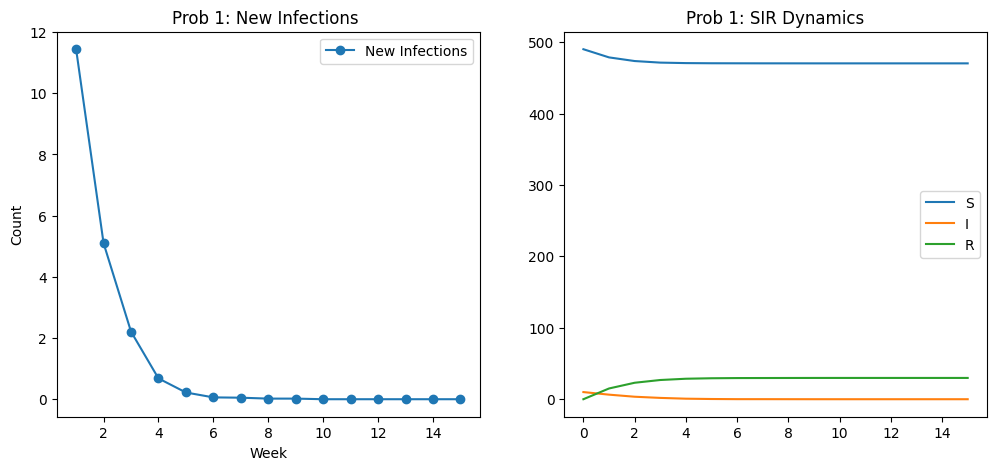

In [4]:
# Run Problem 1 (100 Simulations)
avg_new_1 = np.zeros(weeks)
avg_S_1 = np.zeros(weeks+1)
avg_I_1 = np.zeros(weeks+1)
avg_R_1 = np.zeros(weeks+1)

for _ in range(100):
    ni, s, i, r = run_sir_sim(W_ring, n, beta, rho, weeks, n_initial)
    avg_new_1 += ni
    avg_S_1 += s
    avg_I_1 += i
    avg_R_1 += r

avg_new_1 /= 100
avg_S_1 /= 100
avg_I_1 /= 100
avg_R_1 /= 100

# Plot Problem 1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), avg_new_1, 'o-', label='New Infections')
plt.title('Prob 1: New Infections ')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_S_1, label='S')
plt.plot(avg_I_1, label='I')
plt.plot(avg_R_1, label='R')
plt.title('Prob 1: SIR Dynamics')
plt.legend()
plt.show()

## Problem 2: Epidemic on Random Graph (No Vaccination)
**Setup**: Preferential Attachment graph, $k_{avg}=6$.

In [5]:
def generate_pa_graph(n_nodes, k_avg):
    
    m_start = int(k_avg) + 1
    G = nx.complete_graph(m_start)
    
    c_min = int(np.floor(k_avg / 2))
    c_max = int(np.ceil(k_avg / 2))
    
    for i in range(m_start, n_nodes):
        c = c_min if i % 2 == 0 else c_max
        degrees = np.array([d for _, d in G.degree()])
        probs = degrees / degrees.sum()
        targets = np.random.choice(G.nodes(), size=c, replace=False, p=probs)
        G.add_node(i)
        for t in targets: G.add_edge(i, t)
            
    return nx.to_scipy_sparse_array(G)


W_random = generate_pa_graph(500, 6)


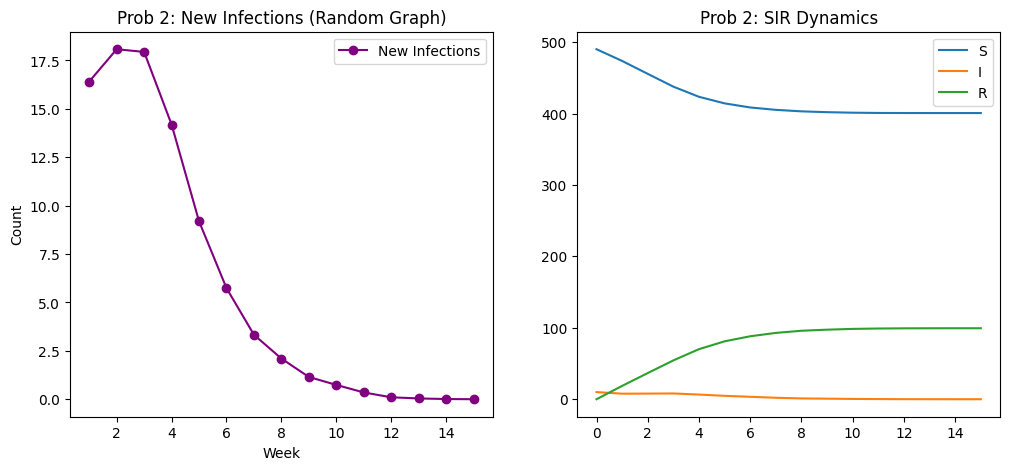

In [6]:
# Run Problem 2 
avg_new_2 = np.zeros(weeks)
avg_S_2 = np.zeros(weeks+1)
avg_I_2 = np.zeros(weeks+1)
avg_R_2 = np.zeros(weeks+1)

for _ in range(100):
    ni, s, i, r = run_sir_sim(W_random, 500, 0.3, 0.7, 15, 10)
    avg_new_2 += ni
    avg_S_2 += s
    avg_I_2 += i
    avg_R_2 += r

avg_new_2 /= 100
avg_S_2 /= 100
avg_I_2 /= 100
avg_R_2 /= 100

# Plot Problem 2
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), avg_new_2, 'o-', color='purple', label='New Infections')
plt.title('Prob 2: New Infections (Random Graph)')
plt.xlabel('Week')
plt.ylabel('Count') 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_S_2, label='S')
plt.plot(avg_I_2, label='I')
plt.plot(avg_R_2, label='R')
plt.title('Prob 2: SIR Dynamics')
plt.legend(); 
plt.show()

## Problem 3: Epidemic with Vaccination
**Setup**: Same graph as Problem 2, but adding Vaccination state (V) and schedule.

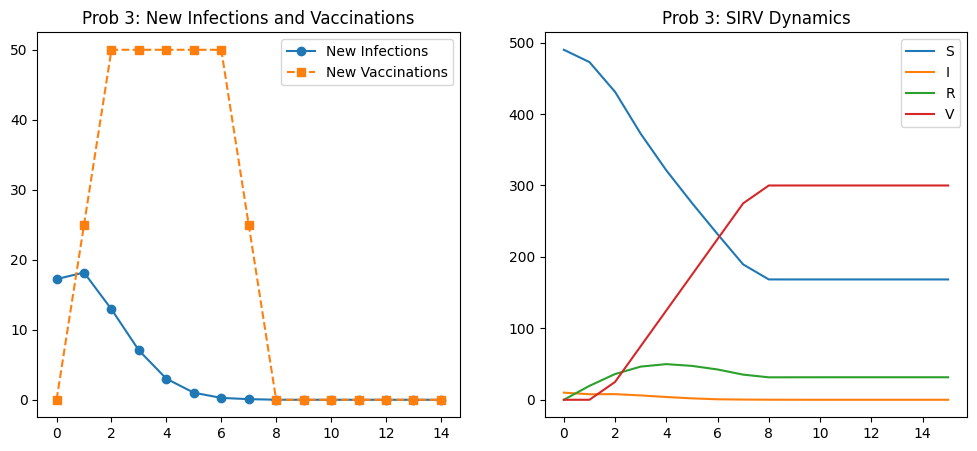

In [7]:
vacc_schedule = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

def run_sirv_sim(adj, n_nodes, b, r, n_weeks, v_sched, init_count=10):
    """Runs SIRV simulation with weekly vaccination schedule."""
    state = np.zeros(n_nodes, dtype=int) # 0:S, 1:I, 2:R, 3:V
    
    # Seed
    seeds = np.random.choice(n_nodes, init_count, replace=False)
    state[seeds] = 1
    
    new_inf_hist = np.zeros(n_weeks)
    new_vac_hist = np.zeros(n_weeks)
    
    S_hist = np.zeros(n_weeks + 1)
    I_hist = np.zeros(n_weeks + 1)
    R_hist = np.zeros(n_weeks + 1)
    V_hist = np.zeros(n_weeks + 1)
    
    S_hist[0] = np.sum(state == 0)
    I_hist[0] = np.sum(state == 1)
    R_hist[0] = np.sum(state == 2)
    V_hist[0] = np.sum(state == 3)
    
    for t in range(n_weeks):
        # 1. Vaccination
        target_pct = v_sched[t]
        target_count = int(n_nodes * target_pct / 100)
        current_v = np.sum(state == 3)
        needed = target_count - current_v
        
        if needed > 0:
            candidates = np.where(state != 3)[0]
            if len(candidates) > 0:
                chosen = np.random.choice(candidates, min(len(candidates), needed), replace=False)
                state[chosen] = 3
                new_vac_hist[t] = len(chosen)
        
        # 2. Infection
        is_I = (state == 1).astype(int)
        m = adj.dot(is_I)
        prob = 1 - (1 - b)**m
        
        r_vals = np.random.rand(n_nodes)
        new_inf = (state == 0) & (r_vals < prob)
        state[new_inf] = 1
        new_inf_hist[t] = np.sum(new_inf)
        
        # 3. Recovery
        r_rec = np.random.rand(n_nodes)
        recovered = (state == 1) & (r_rec < r)
        state[recovered] = 2
        
        # Save stats
        S_hist[t+1] = np.sum(state == 0)
        I_hist[t+1] = np.sum(state == 1)
        R_hist[t+1] = np.sum(state == 2)
        V_hist[t+1] = np.sum(state == 3)
        
    return new_inf_hist, new_vac_hist, S_hist, I_hist, R_hist, V_hist

# Run Problem 3
avg_ni_3 = np.zeros(15)
avg_nv_3 = np.zeros(15)
avg_S_3 = np.zeros(16)
avg_I_3 = np.zeros(16)
avg_R_3 = np.zeros(16)
avg_V_3 = np.zeros(16)

for _ in range(100):
    ni, nv, s, i, r, v = run_sirv_sim(W_random, 500, 0.3, 0.7, 15, vacc_schedule, 10)
    avg_ni_3 += ni
    avg_nv_3 += nv
    avg_S_3 += s
    avg_I_3 += i
    avg_R_3 += r
    avg_V_3 += v

# Average
avg_ni_3 /= 100
avg_nv_3 /= 100
avg_S_3 /= 100
avg_I_3 /= 100
avg_R_3 /= 100
avg_V_3 /= 100

# Plot Problem 3
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_ni_3, 'o-', label='New Infections')
plt.plot(avg_nv_3, 's--', label='New Vaccinations')
plt.title('Prob 3: New Infections and Vaccinations') 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_S_3, label='S')
plt.plot(avg_I_3, label='I')
plt.plot(avg_R_3, label='R')
plt.plot(avg_V_3, label='V')
plt.title('Prob 3: SIRV Dynamics')
plt.legend()
plt.show()

## Problem 4: H1N1 Parameter Estimation (Adaptive Strategy)

**Strategy**: As per the Hint, we start with **large steps** (0.1) to find the correct region quickly. When the algorithm gets stuck, we **halve the step size** and continue to refine the result. This avoids getting trapped in flat areas early on.

In [8]:
# Real Data
N_sweden = 934
v_real = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60])
I0_real = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])
target_inf = I0_real[1:]
init_c = I0_real[0]

# Initial Guesses
k_curr, b_curr, r_curr = 10, 0.3, 0.6

# Start with LARGE steps 
dk = 1
dbeta = 0.1
drho = 0.1
min_step_size = 0.02 # Stop when steps get this small

loop = 0



while True:
    loop += 1
    print(f"\nIteration {loop} (Current: {k_curr}, {b_curr:.3f}, {r_curr:.3f})")
    print(f"Step Sizes -> Beta: {dbeta:.3f}, Rho: {drho:.3f}")
    
    # 1. Define Neighbors
    k_opts = [k_curr - dk, k_curr, k_curr + dk]
    b_opts = [b_curr - dbeta, b_curr, b_curr + dbeta]
    r_opts = [r_curr - drho, r_curr, r_curr + drho]
    
    best_local_rmse = float('inf')
    best_local_p = None
    
    
    for k_val in k_opts:
        if k_val < 2: continue
        for b_val in b_opts:
            if not (0 <= b_val <= 1): continue
            for r_val in r_opts:
                if not (0 <= r_val <= 1): continue
                
                
                temp_inf_sum = np.zeros(15)
                for _ in range(10):
                    g_temp = generate_pa_graph(N_sweden, k_val)
                    ni, _, _, _, _, _ = run_sirv_sim(g_temp, N_sweden, b_val, r_val, 15, v_real, init_c)
                    temp_inf_sum += ni
                
                avg_inf = temp_inf_sum / 10
                rmse = np.sqrt(np.mean((avg_inf - target_inf)**2))
                
                if rmse < best_local_rmse:
                    best_local_rmse = rmse
                    best_local_p = (k_val, b_val, r_val)
    
    print(f"Best Neighbor: {best_local_p} (RMSE: {best_local_rmse:.4f})")
    
    
    if best_local_p == (k_curr, b_curr, r_curr):
        if dbeta > min_step_size:
            
            dbeta /= 2
            drho /= 2
           
        else:
            break
    else:
        k_curr, b_curr, r_curr = best_local_p

print(f"\nFINAL PARAMETERS: k={k_curr}, beta={b_curr:.3f}, rho={r_curr:.3f}")


Iteration 1 (Current: 10, 0.300, 0.600)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (10, 0.3, 0.5) (RMSE: 6.4352)

Iteration 2 (Current: 10, 0.300, 0.500)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (11, 0.19999999999999998, 0.4) (RMSE: 4.7403)

Iteration 3 (Current: 11, 0.200, 0.400)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (11, 0.19999999999999998, 0.30000000000000004) (RMSE: 5.4444)

Iteration 4 (Current: 11, 0.200, 0.300)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (12, 0.19999999999999998, 0.4) (RMSE: 4.4100)

Iteration 5 (Current: 12, 0.200, 0.400)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (11, 0.19999999999999998, 0.4) (RMSE: 6.4055)

Iteration 6 (Current: 11, 0.200, 0.400)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (11, 0.3, 0.5) (RMSE: 5.6368)

Iteration 7 (Current: 11, 0.300, 0.500)
Step Sizes -> Beta: 0.100, Rho: 0.100
Best Neighbor: (10, 0.3, 0.5) (RMSE: 6.3568)

Iteration 8 (Current: 10, 0.300, 0.500)
Step Sizes 

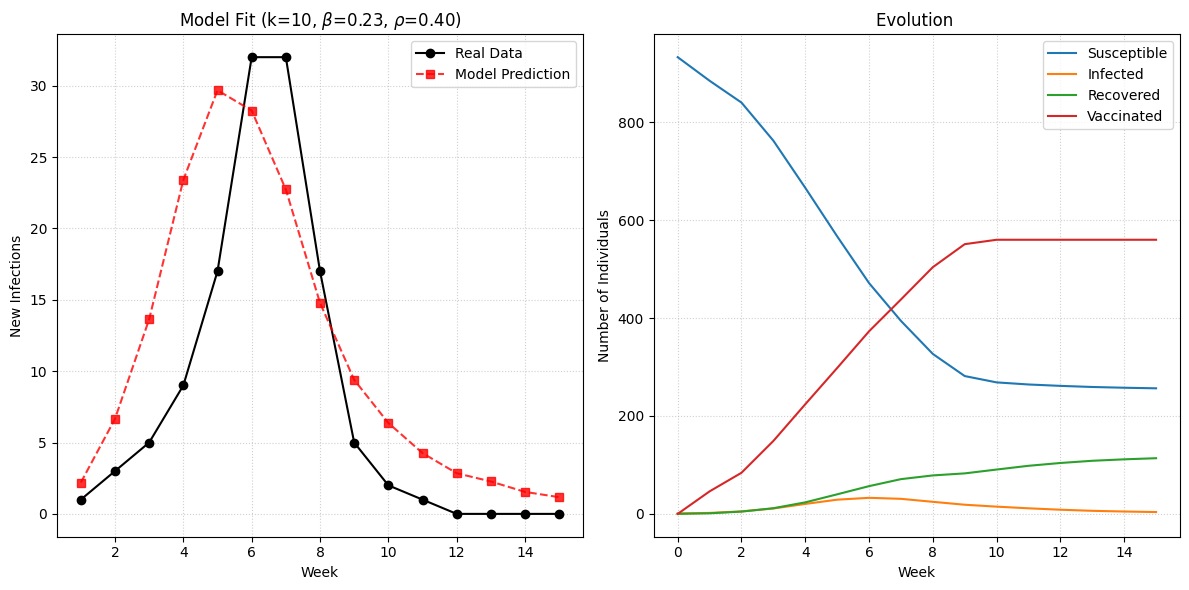

In [9]:
n_sims = 100 


avg_new_inf = np.zeros(15)
avg_S = np.zeros(16)
avg_I = np.zeros(16)
avg_R = np.zeros(16)
avg_V = np.zeros(16)


for i in range(n_sims):
    
    g_val = generate_pa_graph(N_sweden, k_curr)
    ni, _, s, i, r, v = run_sirv_sim(g_val, N_sweden, b_curr, r_curr, 15, v_real, init_c)
    
  
    avg_new_inf += ni
    avg_S += s
    avg_I += i
    avg_R += r
    avg_V += v


avg_new_inf /= n_sims
avg_S /= n_sims
avg_I /= n_sims
avg_R /= n_sims
avg_V /= n_sims


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(range(1, 16), target_inf, 'ko-', label='Real Data', linewidth=1.5)
plt.plot(range(1, 16), avg_new_inf, 'r--s', label='Model Prediction', alpha=0.8)
plt.title(f"Model Fit (k={k_curr}, $\\beta$={b_curr:.2f}, $\\rho$={r_curr:.2f})")
plt.xlabel("Week")
plt.ylabel("New Infections")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)


plt.subplot(1, 2, 2)
plt.plot(avg_S, label='Susceptible')
plt.plot(avg_I, label='Infected')
plt.plot(avg_R, label='Recovered')
plt.plot(avg_V, label='Vaccinated')
plt.title("Evolution ")
plt.xlabel("Week")
plt.ylabel("Number of Individuals")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()